# R4 on Salient ImageNet

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from models.R4_models import SalientImageNet
from models.pipeline import (train_model_with_certified_input_grad, train_model_with_pgd_robust_input_grad,
                             accumulate_model_with_certified_input_grad, test_model_accuracy, test_delta_input_robustness,
                             write_results_to_file, uniformize_magnitudes_schedule, train_model_with_smoothed_input_grad)
from datasets import salient_imagenet
from metrics import worst_group_acc, worst_group_acc_no_load
from torchvision.models import ResNet18_Weights

# Get the dataloaders 

In [2]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
DELTA_INPUT_ROBUSTNESS_PARAM = 1
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)
batch_size = 250
test_batch_size = 250

cuda:1


In [3]:
DATA_DIR = "/vol/bitbucket/mg2720/imagenet100_data"
VAL_DIR = "/vol/bitbucket/mg2720/val.X"
MASKS_DIR = "/vol/bitbucket/mg2720/salient_imagenet_dataset"

# train_imgnet = salient_imagenet.ImageNetDataset(DATA_DIR, MASKS_DIR, True)
# test_imgnet = salient_imagenet.ImageNetDataset(DATA_DIR, MASKS_DIR, False)
train_imgnet = salient_imagenet.LazyImageNetTrainDataset(DATA_DIR, MASKS_DIR, preprocess=(ResNet18_Weights.DEFAULT.transforms()))
test_imgnet = salient_imagenet.LazyImageNetTestDataset(VAL_DIR, MASKS_DIR, preprocess=(ResNet18_Weights.DEFAULT.transforms()))
print(len(train_imgnet), len(test_imgnet))
print(train_imgnet[0][0].shape)


AttributeError: module 'datasets.salient_imagenet' has no attribute 'LazyImageNetTrainDataset'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
3
torch.Size([3, 224, 224])
tensor(2.6226) tensor(-2.1179)
tensor(2)


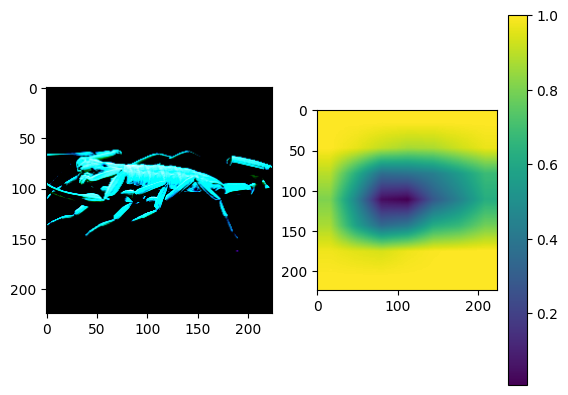

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
torch.Size([3, 224, 224])
tensor(2.3263) tensor(-2.0665)
tensor(5)


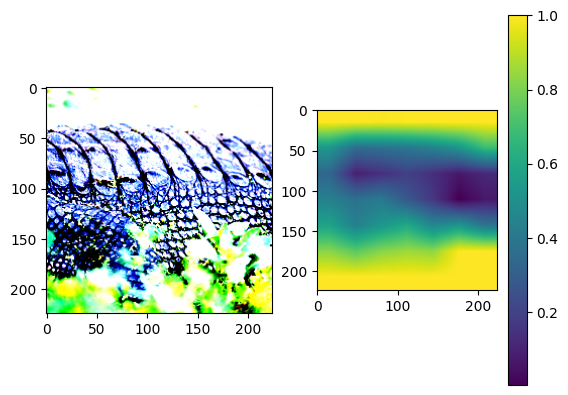

In [7]:
print((train_imgnet[0][2]).shape)
img, img_label, img_mask = None, None, None
rand_5 = torch.randint(0, len(train_imgnet), (10,))
for i in rand_5:
    img, img_label, img_mask = train_imgnet[i]
    if not torch.all(img_mask[0] == 0):
        print(img_mask.shape[0])
        print(img.shape)
        print(torch.max(img), torch.min(img))
        print(img_label)
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img.float().permute(1, 2, 0).squeeze().numpy())
        im_mask = ax[1].imshow(img_mask[0].numpy())
        fig.colorbar(im_mask, ax=ax[1])
        plt.show()

In [8]:
dl_train = salient_imagenet.get_dataloader(train_imgnet, batch_size)
dl_test = salient_imagenet.get_dataloader(test_imgnet, test_batch_size)
criterion = torch.nn.CrossEntropyLoss()

## Experiments 

In [9]:
model_root_save_dir = "saved_experiment_models/performance/imagenet"
os.makedirs(model_root_save_dir, exist_ok=True)
methods = ["r4", "pgd_r4", "std", "pgd_r4_pmo", "smooth_r3", "smooth_r3_small", "rand_r4_pmo", "rand_r4", "std_small", "pgd_r4_pmo_small",
           "pgd_r4_small", "rand_r4_pmo_small", "rand_r4_small"]
save_dir_for_method = {method: os.path.join(model_root_save_dir, method) for method in methods}
for method in methods:
    os.makedirs(save_dir_for_method[method], exist_ok=True)

### Standard Training

In [ ]:
std_method = "std"
# Hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_coeff = 5, 1e-4, 1, -1, -1, -1
# k is a coefficient for the regularization term
train_acc, test_acc = 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()
    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[std_method], f"run_{i}.pt"))
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
empty_model = SalientImageNet()
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 6, save_dir_for_method[std_method])
write_results_to_file("experiment_results/imagenet.yaml",
                        {"train_acc": round(train_acc / restarts, 3),
                         "test_acc": round(test_acc / restarts, 3),
                         "worst_group_acc": round(wg_acc, 3),
                         "worst_group": wg}, std_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts}, std_method)

# PGD_R4 Training

In [ ]:
pgd_r4 = "pgd_r4" # Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 7, 1e-4, 3, 0.01, 1e-5, 0.3
train_acc, test_acc = 0, 0
new_batch_size = 262
dl_train = salient_imagenet.get_dataloader(train_imgnet, new_batch_size, drop_last=True)
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()

    print(f"========== Training model with method {pgd_r4} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, pgd_r4,
        k, device, weight_reg_coeff=weight_coeff, num_iterations=5)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[pgd_r4], f"run_{i}.pt"))
empty_model = SalientImageNet()
wg_acc, wg = worst_group_acc(curr_model, dl_test, device, 6, save_dir_for_method[pgd_r4])
write_results_to_file("experiment_results/imagenet.yaml",
                      {"train_acc": round(train_acc / restarts, 4),
                       "test_acc": round(test_acc / restarts, 4),
                       "worst_group_acc": round(wg_acc, 4),
                       "worst_group": wg,}, pgd_r4)
write_results_to_file("experiment_results/imagenet_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts}, pgd_r4)

========== Training model with method pgd_r4 restart 0 ==========


Epoch: 100%|██████████| 7/7 [21:57<00:00, 188.23s/it, loss=2.67, reg=tensor(5.4140, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.96
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.96
Worst class accuracy = 0.92 for class 4
========== Training model with method pgd_r4 restart 1 ==========


Epoch: 100%|██████████| 7/7 [20:40<00:00, 177.15s/it, loss=2.31, reg=tensor(4.2285, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.98
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.98
Worst class accuracy = 0.96 for class 2
========== Training model with method pgd_r4 restart 2 ==========


Epoch: 100%|██████████| 7/7 [20:36<00:00, 176.69s/it, loss=2.42, reg=tensor(4.5822, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.97
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.97
Worst class accuracy = 0.92 for class 3
Worst class accuracy = 0.94 for class 3


# PGD_R4 perturb mask only Training

In [ ]:
pgd_r4_pmo = "pgd_r4_pmo" # Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 7, 1e-4, 3, 0.03, 1e-5, 0.3
train_acc, test_acc = 0, 0
new_batch_size = 262
dl_train = salient_imagenet.get_dataloader(train_imgnet, new_batch_size, drop_last=True)
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()

    print(f"========== Training model with method {pgd_r4_pmo} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, pgd_r4_pmo,
        k, device, weight_reg_coeff=weight_coeff, num_iterations=5)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[pgd_r4_pmo], f"run_{i}.pt"))
empty_model = SalientImageNet()
wg_acc, wg = worst_group_acc(curr_model, dl_test, device, 6, save_dir_for_method[pgd_r4_pmo])
write_results_to_file("experiment_results/imagenet.yaml",
                      {"train_acc": round(train_acc / restarts, 4),
                       "test_acc": round(test_acc / restarts, 4),
                       "worst_group_acc": round(wg_acc, 4),
                       "worst_group": wg,}, pgd_r4_pmo)
write_results_to_file("experiment_results/imagenet_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts}, pgd_r4_pmo)

# Smoothed-R3 Training

In [11]:
smooth_r3 = "smooth_r3"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 7, 8e-5, 3, 0.01, 1e-6, 0.4
train_acc, test_acc = 0, 0
new_batch_size = 262
dl_train = salient_imagenet.get_dataloader(train_imgnet, new_batch_size, drop_last=True)
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()

    print(f"========== Training model with method {smooth_r3} restart {i} ==========")
    train_model_with_smoothed_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, smooth_r3, k,
        device, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[smooth_r3], f"run_{i}.pt"))
empty_model = SalientImageNet()
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 6, save_dir_for_method[smooth_r3])
write_results_to_file("experiment_results/imagenet.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "worst_group_acc": round(wg_acc, 3),
                       "worst_group": wg}, smooth_r3)
write_results_to_file("experiment_results/imagenet_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts}, smooth_r3)

========== Training model with method smooth_r3 restart 0 ==========


Epoch: 100%|██████████| 7/7 [09:49<00:00, 84.26s/it, loss=1.05, reg=tensor(0.0019, device='cuda:1', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.97
Worst class accuracy = 0.92 for class 3
========== Training model with method smooth_r3 restart 1 ==========


Epoch: 100%|██████████| 7/7 [09:36<00:00, 82.41s/it, loss=1.05, reg=tensor(0.0019, device='cuda:1', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.98
Worst class accuracy = 0.96 for class 3
========== Training model with method smooth_r3 restart 2 ==========


Epoch: 100%|██████████| 7/7 [09:36<00:00, 82.33s/it, loss=1.05, reg=tensor(0.0019, device='cuda:1', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.98
Worst class accuracy = 0.94 for class 3
Worst class accuracy = 0.94 for class 3


# --------------------- SMALL DATASET ----------------------

In [4]:
DATA_DIR = "/vol/bitbucket/mg2720/imagenet100_data"
VAL_DIR = "/vol/bitbucket/mg2720/val.X"
MASKS_DIR = "/vol/bitbucket/mg2720/salient_imagenet_dataset"

train_imgnet = salient_imagenet.LazyImageNetDataset(DATA_DIR, MASKS_DIR, preprocess=(ResNet18_Weights.DEFAULT.transforms()),
                                                    skip_empty_masks=True, is_train=True)
test_imgnet = salient_imagenet.LazyImageNetDataset(DATA_DIR, MASKS_DIR, preprocess=(ResNet18_Weights.DEFAULT.transforms()),
                                                   skip_empty_masks=True, is_train=False)
print(len(train_imgnet))
print(len(test_imgnet))
dl_train = salient_imagenet.get_dataloader(train_imgnet, batch_size)
dl_test = salient_imagenet.get_dataloader(test_imgnet, test_batch_size)
criterion = torch.nn.CrossEntropyLoss()

1560
390


In [ ]:
std_method = "std"
# Hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_coeff = 20, 1e-3, 1, -1, -1, -1
# k is a coefficient for the regularization term
train_acc, test_acc = 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()
    print(f"========== Training model with method {std_method} small restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
#     torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[std_method + "_small"], f"run_{i}.pt"))
# empty_model = SalientImageNet()
# wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 6, save_dir_for_method[std_method + "_small"])
# write_results_to_file("experiment_results/imagenet_small.yaml",
#                         {"train_acc": round(train_acc / restarts, 4),
#                          "test_acc": round(test_acc / restarts, 4),
#                          "worst_group_acc": round(wg_acc, 4),
#                          "worst_group": wg}, std_method)
# write_results_to_file("experiment_results/imagenet_small_params.yaml",
#                         {"epsilon": epsilon,
#                          "k": k,
#                          "weight_coeff": weight_coeff,
#                          "num_epochs": num_epochs,
#                          "lr": lr,
#                          "restarts": restarts}, std_method)

========== Training model with method std small restart 0 ==========


Epoch: 100%|██████████| 20/20 [04:06<00:00, 12.31s/it]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.2506
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.04872
Worst class accuracy = 0 for class 1


In [ ]:
pgd_r4 = "pgd_r4" # Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 8, 1e-4, 3, 0.01, 1e-5, 0.6
train_acc, test_acc = 0, 0
new_batch_size = 262
dl_train = salient_imagenet.get_dataloader(train_imgnet, new_batch_size, drop_last=True)
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()

    print(f"========== Training model with method {pgd_r4} small restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, pgd_r4,
        k, device, weight_reg_coeff=weight_coeff, num_iterations=5)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[pgd_r4+ "_small"], f"run_{i}.pt"))
empty_model = SalientImageNet()
wg_acc, wg = worst_group_acc(curr_model, dl_test, device, 6, save_dir_for_method[pgd_r4 + "_small"])
write_results_to_file("experiment_results/imagenet_small.yaml",
                      {"train_acc": round(train_acc / restarts, 4),
                       "test_acc": round(test_acc / restarts, 4),
                       "worst_group_acc": round(wg_acc, 4),
                       "worst_group": wg,}, pgd_r4)
write_results_to_file("experiment_results/imagenet_small_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts}, pgd_r4)

========== Training model with method pgd_r4 small restart 0 ==========


Epoch: 100%|██████████| 8/8 [02:53<00:00, 21.67s/it, loss=9.39, reg=tensor(13.9078, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.91
Worst class accuracy = 0.82 for class 3
========== Training model with method pgd_r4 small restart 1 ==========


Epoch: 100%|██████████| 8/8 [02:54<00:00, 21.77s/it, loss=8.96, reg=tensor(13.1998, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.92
Worst class accuracy = 0.82 for class 3
========== Training model with method pgd_r4 small restart 2 ==========


Epoch: 100%|██████████| 8/8 [02:49<00:00, 21.20s/it, loss=11.3, reg=tensor(17.0765, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.93
Worst class accuracy = 0.84 for class 3
Worst class accuracy = 0.8267 for class 3


In [ ]:
pgd_r4_pmo = "pgd_r4_pmo" # Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 8, 1e-4, 3, 0.03, 1e-5, 1
train_acc, test_acc = 0, 0
new_batch_size = 262
dl_train = salient_imagenet.get_dataloader(train_imgnet, new_batch_size, drop_last=True)
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()

    print(f"========== Training model with method {pgd_r4_pmo} small restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, pgd_r4_pmo,
        k, device, weight_reg_coeff=weight_coeff, num_iterations=10)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[pgd_r4_pmo + "_small"], f"run_{i}.pt"))
empty_model = SalientImageNet()
wg_acc, wg = worst_group_acc(curr_model, dl_test, device, 6, save_dir_for_method[pgd_r4_pmo + "_small"])
write_results_to_file("experiment_results/imagenet_small.yaml",
                      {"train_acc": round(train_acc / restarts, 4),
                       "test_acc": round(test_acc / restarts, 4),
                       "worst_group_acc": round(wg_acc, 4),
                       "worst_group": wg,}, pgd_r4_pmo)
write_results_to_file("experiment_results/imagenet_small_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts}, pgd_r4_pmo)

========== Training model with method pgd_r4_pmo small restart 0 ==========


Epoch: 100%|██████████| 8/8 [03:37<00:00, 27.14s/it, loss=25.5, reg=tensor(24.4300, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.91
Worst class accuracy = 0.82 for class 3
========== Training model with method pgd_r4_pmo small restart 1 ==========


Epoch: 100%|██████████| 8/8 [03:36<00:00, 27.09s/it, loss=22.2, reg=tensor(21.1355, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9167
Worst class accuracy = 0.78 for class 3
========== Training model with method pgd_r4_pmo small restart 2 ==========


Epoch: 100%|██████████| 8/8 [03:35<00:00, 26.99s/it, loss=22.1, reg=tensor(21.0474, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9333
Worst class accuracy = 0.8 for class 3
Worst class accuracy = 0.8 for class 3


In [35]:
smooth_r3 = "smooth_r3"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 10, 8e-5, 3, 0.01, 1e-6, 400
train_acc, test_acc = 0, 0
new_batch_size = 150
dl_train = salient_imagenet.get_dataloader(train_imgnet, new_batch_size)
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()

    print(f"========== Training model with method {smooth_r3} restart {i} ==========")
    train_model_with_smoothed_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, smooth_r3, k,
        device, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[smooth_r3 + "_small"], f"run_{i}.pt"))
empty_model = SalientImageNet()
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 6, save_dir_for_method[smooth_r3 + "_small"])
write_results_to_file("experiment_results/imagenet_small.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "worst_group_acc": round(wg_acc, 3),
                       "worst_group": wg}, smooth_r3)
write_results_to_file("experiment_results/imagenet_small_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts}, smooth_r3)

========== Training model with method smooth_r3 restart 0 ==========


Epoch: 100%|██████████| 10/10 [03:28<00:00, 20.89s/it, loss=2.73, reg=tensor(1.6836, device='cuda:1', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9333
Worst class accuracy = 0.82 for class 3
========== Training model with method smooth_r3 restart 1 ==========


Epoch: 100%|██████████| 10/10 [03:31<00:00, 21.20s/it, loss=2.72, reg=tensor(1.6776, device='cuda:1', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9333
Worst class accuracy = 0.86 for class 3
========== Training model with method smooth_r3 restart 2 ==========


Epoch: 100%|██████████| 10/10 [03:30<00:00, 21.09s/it, loss=2.73, reg=tensor(1.6850, device='cuda:1', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.94
Worst class accuracy = 0.82 for class 3
Worst class accuracy = 0.8333 for class 3


In [13]:
rand_r4_pmo = "rand_r4_pmo"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 7, 8e-5, 3, 0.03, 0, 2e+5
train_acc, test_acc = 0, 0
new_batch_size = 150
dl_train = salient_imagenet.get_dataloader(train_imgnet, new_batch_size)
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()

    print(f"========== Training model with method {rand_r4_pmo} small restart {i} ==========")
    train_model_with_smoothed_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, rand_r4_pmo, k,
        device, weight_reg_coeff=weight_coeff, perturb_mask_only=True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[rand_r4_pmo + "_small"], f"run_{i}.pt"))
empty_model = SalientImageNet()
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 6, save_dir_for_method[rand_r4_pmo + "_small"])
write_results_to_file("experiment_results/imagenet_small.yaml",
                      {"train_acc": round(train_acc / restarts, 4),
                       "test_acc": round(test_acc / restarts, 4),
                       "worst_group_acc": round(wg_acc, 4),
                       "worst_group": wg}, rand_r4_pmo)
write_results_to_file("experiment_results/imagenet_small_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, rand_r4_pmo)

========== Training model with method rand_r4_pmo small restart 0 ==========


Epoch: 100%|██████████| 7/7 [09:14<00:00, 79.17s/it, loss=1.17, reg=tensor(0.1210, device='cuda:1', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9633
Worst class accuracy = 0.92 for class 3
========== Training model with method rand_r4_pmo small restart 1 ==========


Epoch: 100%|██████████| 7/7 [09:25<00:00, 80.76s/it, loss=1.11, reg=tensor(0.0691, device='cuda:1', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9667
Worst class accuracy = 0.9 for class 3
========== Training model with method rand_r4_pmo small restart 2 ==========


Epoch: 100%|██████████| 7/7 [09:38<00:00, 82.63s/it, loss=1.11, reg=tensor(0.0671, device='cuda:1', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.98
Worst class accuracy = 0.96 for class 3
Worst class accuracy = 0.9267 for class 3
